## Train Onet on rendered images

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("..")

---

In [2]:
args = {
    'config': 'configs/img/onet_aug_from_pretrain.yaml',
    'no_cuda': True,
    'exit_after': -1
}

In [3]:
import torch
import torch.optim as optim
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib; matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO

/home/phuc/miniconda3/envs/mesh_funcspace/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
cfg = config.load_config(args["config"], 'configs/default.yaml')
is_cuda = (torch.cuda.is_available() and not args["no_cuda"])
device = torch.device("cuda" if is_cuda else "cpu")

In [5]:
# Shorthands
out_dir = cfg['training']['out_dir']
batch_size = cfg['training']['batch_size']
backup_every = cfg['training']['backup_every']
exit_after = args["exit_after"]

In [6]:
model_selection_metric = cfg['training']['model_selection_metric']
if cfg['training']['model_selection_mode'] == 'maximize':
    model_selection_sign = 1
elif cfg['training']['model_selection_mode'] == 'minimize':
    model_selection_sign = -1
else:
    raise ValueError('model_selection_mode must be '
                     'either maximize or minimize.')

In [7]:
# Output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [8]:
cfg

{'method': 'onet',
 'data': {'dataset': 'Shapes3D',
  'path': 'data/ShapeNet',
  'classes': None,
  'input_type': 'img',
  'train_split': 'train',
  'val_split': 'val',
  'test_split': 'test',
  'dim': 3,
  'points_file': 'points.npz',
  'points_iou_file': 'points.npz',
  'points_subsample': 2048,
  'points_unpackbits': True,
  'model_file': 'model.off',
  'watertight_file': 'model_watertight.off',
  'img_folder': 'img_phuc2019',
  'img_size': 224,
  'img_with_camera': False,
  'img_augment': True,
  'img_ext': 'png',
  'bg_augment': 1.0,
  'scale_limit': 0.0,
  'n_views': 24,
  'pointcloud_file': 'pointcloud.npz',
  'pointcloud_chamfer_file': 'pointcloud.npz',
  'pointcloud_n': 256,
  'pointcloud_target_n': 1024,
  'pointcloud_noise': 0.05,
  'voxels_file': 'model.binvox',
  'with_transforms': False,
  'with_gt': False,
  'bg_folder': 'data/indoor_images'},
 'model': {'decoder': 'cbatchnorm',
  'encoder': 'resnet18',
  'encoder_latent': None,
  'decoder_kwargs': {},
  'encoder_kwargs'

In [9]:
# Dataset
train_dataset = config.get_dataset('train', cfg)
val_dataset = config.get_dataset('val', cfg)

### Train

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms import transforms

In [11]:
len(train_dataset)

30811

#### Train input

In [12]:
sample = train_dataset[np.random.randint(0, len(train_dataset))]

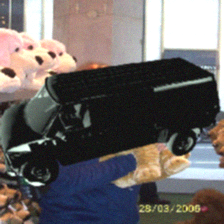

In [13]:
transforms.ToPILImage()(sample['inputs'])

#### Train output

In [16]:
points = sample.get('points')
points.shape

(2048, 3)

In [17]:
points_occ = sample.get('points.occ')
points_occ.shape

(2048,)

In [18]:
np.unique(points_occ)

array([0., 1.], dtype=float32)

### Data loader

In [19]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=4, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

In [20]:
batch = next(iter(train_loader))

In [21]:
batch_size

64

In [22]:
len(batch['inputs'])

64

In [23]:
print(batch.get('points').shape)
print(batch.get('points.occ').shape)
print(batch.get('inputs').shape)

torch.Size([64, 2048, 3])
torch.Size([64, 2048])
torch.Size([64, 3, 224, 224])


In [ ]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, num_workers=4, shuffle=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn
)

In [ ]:
vis_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=12, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn,
)

In [28]:
data = next(iter(vis_loader))

In [29]:
%debug

> /home/phuc/miniconda3/envs/mesh_funcspace/lib/python3.6/selectors.py(376)select()
    374             ready = []
    375             try:
--> 376                 fd_event_list = self._poll.poll(timeout)
    377             except InterruptedError:
    378                 return ready



ipdb>  exit
